In [1]:
import torch
import numpy as np
import monai
from monai import data

import random

import pandas as pd
from natsort import natsorted
import glob

from tqdm import tqdm
# from sklearn.metrics.pairwise import cosine_similarity

seed = 42
dataset = 'adni2'
classes_to_use = ['CN', 'AD']

if dataset=='adni2':
    df = pd.read_csv("./data/adni2_unique_sorted_13022023.csv")
    dataroot = "./data/ADNI2/"
elif dataset=='adni1':
    df = pd.read_csv("./data/ADNI1_15T_UNIQUE.csv")
    dataroot = "./data/ADNI1_preprocessed_arranged/"

df = df[df['Group'].isin(classes_to_use)]

# Set the seed
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    monai.utils.set_determinism(seed=seed)
    print('Seed is set.')

set_seed(seed)

Seed is set.


In [2]:
from sklearn.model_selection import StratifiedKFold


skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)

folds = {}

for i, (train_index, test_index) in enumerate(skf.split(df, df['Group'])):

    folds[i] = (df.iloc[train_index], df.iloc[test_index])
    
    print(f'Fold {i}: ')
    print(f'Train: {len(folds[i][0])}, Test: {len(folds[i][1])}')
    # print(f'Train balance: {folds[i][0]["Group"].value_counts()}')
    print(f'Test balance: {folds[i][1]["Group"].value_counts()}')
    

Fold 0: 
Train: 270, Test: 90
Test balance: CN    50
AD    40
Name: Group, dtype: int64
Fold 1: 
Train: 270, Test: 90
Test balance: CN    50
AD    40
Name: Group, dtype: int64
Fold 2: 
Train: 270, Test: 90
Test balance: CN    50
AD    40
Name: Group, dtype: int64
Fold 3: 
Train: 270, Test: 90
Test balance: CN    51
AD    39
Name: Group, dtype: int64


In [3]:
def make_kfold_dataloaders(test_df, savename, fold_idx):
    FILENAME_POSTFIX = f'{savename}_{dataset}_seed_{seed}_fold_{fold_idx}'
    
    test_transforms = monai.transforms.Compose([
        monai.transforms.LoadImaged(keys=["image"]),
        monai.transforms.EnsureChannelFirstd(keys=["image",]),
        monai.transforms.Orientationd(keys=["image"], axcodes="RAS"),
        monai.transforms.Spacingd(keys=["image"], pixdim=tuple([1.75, 1.75, 1.75])),
        monai.transforms.CropForegroundd(keys=["image"], source_key="image"),
        monai.transforms.NormalizeIntensityd(keys=["image"], nonzero=True),
        monai.transforms.Resized(keys=["image"], spatial_size=tuple([128, 128, 128])),
        monai.transforms.ToTensord(keys=["image", "label"])
    ])


    nii_list = natsorted(glob.glob(dataroot + '*/hdbet_*[!mask].nii.gz'))
    print(f'{len(nii_list)} nii files found.')
    
    test_datalist = []
    
    for _, row in test_df.iterrows():
        label = classes_to_use.index(row["Group"])
        path_to_file = [x for x in nii_list if row['Subject'] in x and row['Image Data ID'] in x]
        assert len(path_to_file) == 1, f'More than one file found for {row["Subject"]} and {row["Image Data ID"]}'

        test_datalist.append({
            "image": path_to_file[0],
            "label": label
        })

    test_dataset = data.PersistentDataset(data=test_datalist, 
                                          transform=test_transforms, 
                                          cache_dir=f'./monai_logs/test_{FILENAME_POSTFIX}')
    print(f'Test dataset len: {len(test_dataset)}')

    test_dataloader = data.DataLoader(test_dataset, 
                                    batch_size=1,
                                    shuffle=False, 
                                    num_workers=0
                                    )

    ratios_test = {}
    for label in classes_to_use:
        label_id = classes_to_use.index(label)
        ratios_test[label] = sum([1 for x in test_datalist if x['label'] == label_id])

    return test_dataloader, test_dataset

# Measure Feature Diversity

In [4]:
def cosine_similarity(x_i, x_j):
    A_flat = x_i.flatten()
    B_flat = x_j.flatten()

    assert A_flat.shape == B_flat.shape
    # Compute the dot product
    dot_product = np.dot(A_flat, B_flat)
    
    # Compute the L2 norms (magnitudes)
    A_norm = np.linalg.norm(A_flat)
    B_norm = np.linalg.norm(B_flat)
    
    # Compute the cosine similarity
    cosine_similarity = dot_product / (A_norm * B_norm)
    
    return cosine_similarity

def get_cosine_distances(feats):
    data = {}
    max_layer = len(feats)

    distances = []
    
    for i, f in enumerate(feats):
        f = f.squeeze().detach().cpu().numpy()
        # print(f.shape)
        
        c_count = 0
        dist_value = 0
        for c_i in range(f.shape[0]):
            for c_j in range(f.shape[0]):
                if c_i != c_j:
                    c_count += 1
                    dist_value += (1 - cosine_similarity(f[c_i], f[c_j]))/2

                    if i==(max_layer-1):
                        distances.append((1 - cosine_similarity(f[c_i], f[c_j]))/2)
                    
        data[i/max_layer] = dist_value / c_count

    return data, distances

# load models

In [5]:
from utils.utils import load_pretrained_checkpoint
from models.convnextv2_3d import ConvNeXtV2_3D
from models.vit3d import Vision_Transformer3D

def get_model(model_name, checkpoint):
    if 'convnext' in model_name.lower():
        model = ConvNeXtV2_3D(in_chans=1, num_classes=2, drop_path_rate=0.1, 
                            depths = [3, 3, 27, 3], dims=[64, 128, 256, 512],
                            kernel_size=7, padding=3, downsampling='avgpool3d')
    elif 'vit' in model_name.lower():
        model = Vision_Transformer3D(img_size=[128, 128, 128], patch_size=16, in_chans=1, n_classes=2,
                                    embed_dim=768, depth=12, n_heads=12, mlp_ratio=4.0, qkv_bias=True,
                                    drop_path_rate=0.1, p=0.1, attn_p=0.1, global_avg_pool=False,
                                    pos_embed_type='learnable', patch_embed_fun='conv3d')
    else:
        raise ValueError('Model not supported.')

    if 'sparse' in model_name.lower():
        model = load_pretrained_checkpoint(model, checkpoint, 'ConvNext_sparse')
    elif 'vit' in model_name.lower():
        model = load_pretrained_checkpoint(model, checkpoint, 'ViT')
    
    model.eval()
    return model
    



# computation

In [ ]:
models = {
    'ViT': 'checkpoints/wp_noaug_mae75_ixihcp_pretraining_seed_8432_999_053000.pth.tar',
    'ConvNeXt_sparse': 'checkpoints/convnext_sparse_pt_dim128_HCP_IXI__pretraining_seed_42_599_254400.pth.tar',
}


feat_distances = {}

for model_name, checkpoint in models.items():
    model = get_model(model_name, checkpoint)
    print(f'Loaded model: {model_name}')
    
    # model = model.cuda()
    
    distance_data = []
    dist_histograms = []
    
    for fold_idx in range(4):
        dataloader, ds = make_kfold_dataloaders(folds[fold_idx][1], 
                                                checkpoint.replace('.pth.tar', '').replace('checkpoints/', ''), 
                                                fold_idx)
        
        N = len(dataloader)
        
        for batch in tqdm(dataloader, total=N):
            image, labels = batch['image'], batch['label']
            # image = image.cuda()
            with torch.no_grad():
                features = model.get_features(image)
            
            cos_dists, distances = get_cosine_distances(features) 
            # {layer_index: val} 
            distance_data.append(cos_dists) 
            dist_histograms.extend(distances)

    feat_distances[model_name] = distance_data
    
    break
    


Model weights initialized
Loaded pre-trained checkpoint from: checkpoints/wp_noaug_mae75_ixihcp_pretraining_seed_8432_999_053000.pth.tar
['head.weight', 'head.bias']
Loaded model: ViT
839 nii files found.


/usr/local/anaconda3/envs/damit/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


Test dataset len: 90


  1%|          | 1/90 [01:05<1:36:31, 65.08s/it]

# Plot results

In [1]:
# combine datasets
import pickle 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

datasets = ['adni1', 'adni2']
seed = 42

with open('./adni2_feat_distances.pkl', 'rb') as f:
    adni2 = pickle.load(f)

with open('./adni1_feat_distances.pkl', 'rb') as f:
    adni1 = pickle.load(f)

In [20]:
adni1['ViT'][0]

{0.0: 0.41680824544451234,
 0.07692307692307693: 0.39459391157816137,
 0.15384615384615385: 0.3614850126885336,
 0.23076923076923078: 0.33502536561371554,
 0.3076923076923077: 0.3005070249685388,
 0.38461538461538464: 0.28807453437914526,
 0.46153846153846156: 0.26044129646250697,
 0.5384615384615384: 0.2374162016732375,
 0.6153846153846154: 0.21080200544971026,
 0.6923076923076923: 0.1845745445549312,
 0.7692307692307693: 0.17220771012513,
 0.8461538461538461: 0.16332466271252064,
 0.9230769230769231: 0.1651330643353805}

In [21]:
adni2['ViT'][0]

{0.0: 0.4171662188900836,
 0.07692307692307693: 0.3944895945584125,
 0.15384615384615385: 0.365746351807004,
 0.23076923076923078: 0.32589405409711886,
 0.3076923076923077: 0.29871323634907226,
 0.38461538461538464: 0.28548470258619274,
 0.46153846153846156: 0.2622523174305902,
 0.5384615384615384: 0.23883106145968291,
 0.6153846153846154: 0.20335195797936242,
 0.6923076923076923: 0.17291908124273417,
 0.7692307692307693: 0.15776949941287757,
 0.8461538461538461: 0.14839356499682108,
 0.9230769230769231: 0.14960679759761158}

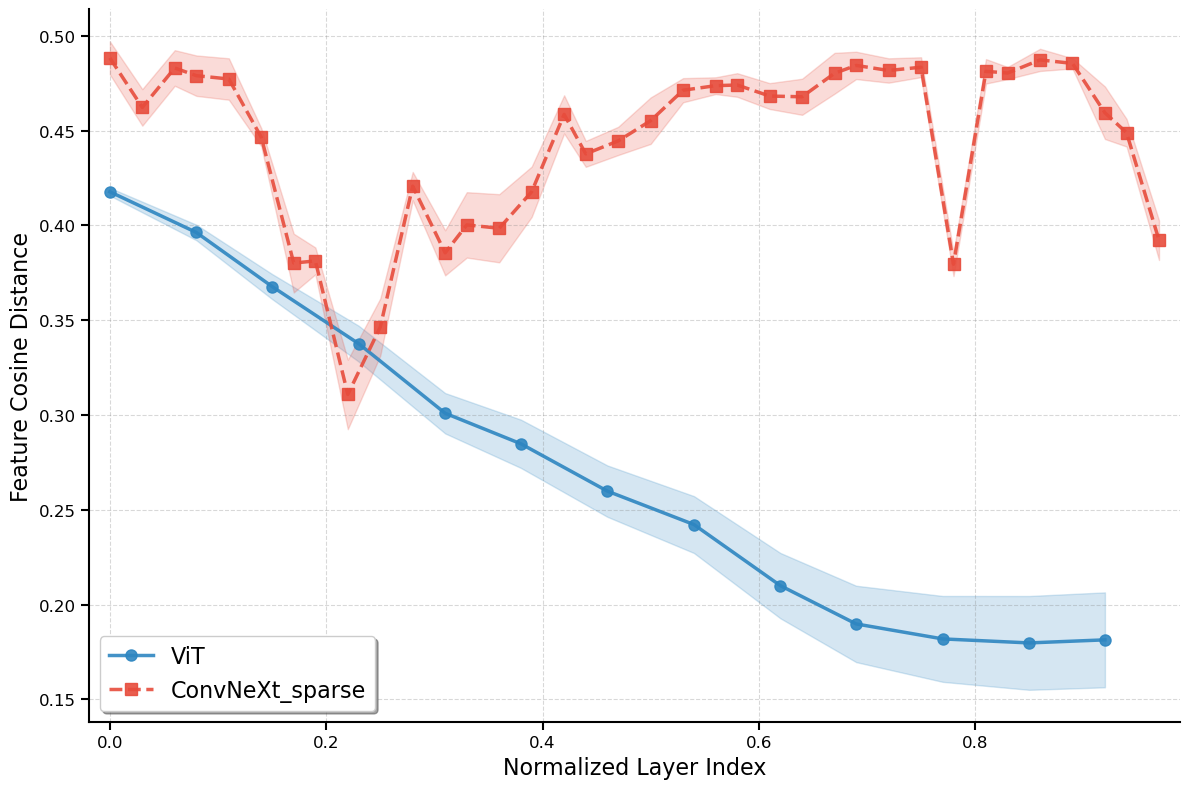

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create figure and axis with larger size
fig, ax = plt.subplots(figsize=(12, 8))

# Define custom colors and styles
colors = ['#2E86C1', '#E74C3C', '#27AE60']  # Blue, Red, Green
markers = ['o', 's', '^']  # Circle, Square, Triangle
line_styles = ['-', '--', '-.']  # Solid, Dashed, Dash-dot

# Plot for each model
for idx, model_name in enumerate(['ViT', 'ConvNeXt_sparse']):
    # Get the data for current model
    model_data_adni2 = adni2[model_name]
    model_data_adni1 = adni1[model_name]
    
    # Calculate average cosine distance for each layer
    layers = {}
    
    for entry in model_data_adni1:
        for k, v in entry.items():
            if round(k, 2) in layers:
                layers[round(k, 2)].append(v)
            else:
                layers[round(k, 2)] = [v]
    
    for entry in model_data_adni2:
        for k, v in entry.items():
            if round(k, 2) in layers:
                layers[round(k, 2)].append(v)
            else:
                layers[round(k, 2)] = [v]
    
    # Calculate mean and std for each layer
    x_values = sorted(layers.keys())
    y_means = []
    y_stds = []
    
    for k in x_values:
        layer_distances = layers[k]
        # Flatten the list of distances if needed
        flat_distances = [item for sublist in layer_distances for item in (sublist if isinstance(sublist, list) else [sublist])]
        y_means.append(np.mean(flat_distances))
        y_stds.append(np.std(flat_distances))
    
    # Plot mean line
    ax.plot(x_values, y_means,
            label=model_name,
            color=colors[idx],
            marker=markers[idx],
            markersize=8,
            linewidth=2.5,
            linestyle=line_styles[idx],
            alpha=0.9)
    
    # Add standard deviation bands
    ax.fill_between(x_values,
                   np.array(y_means) - np.array(y_stds),
                   np.array(y_means) + np.array(y_stds),
                   color=colors[idx],
                   alpha=0.2)

# Customize the plot
plt.xlabel('Normalized Layer Index', fontsize=16)
plt.ylabel('Feature Cosine Distance', fontsize=16)
# plt.title('Average Cosine Distances Across Network Layers\n(Shaded areas show ±1 std)', 
#          fontsize=14, 
#          fontweight='bold', 
#          pad=20)

# Customize grid
plt.grid(True, linestyle='--', alpha=0.3, color='gray')

# Customize legend
plt.legend(fontsize=16, 
         frameon=True, 
         fancybox=True, 
         shadow=True, 
         loc='best')

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)

# Add some padding to the plot
plt.margins(x=0.02)

# Ensure layout fits well
plt.tight_layout()

plt.savefig('./adni1_adni2_feat_distances.pdf', dpi=300)

# Show the plot
plt.show()